In [ ]:
!pip install tabulate

In [ ]:
# Basic packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns
import os, pickle
from tabulate import tabulate
from zipfile import ZipFile

# Machine learning packages
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Métricas de rendimiento
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit

# TensorFlow ≥2.0-preview is required
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tensorflow import keras

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
window = 50               # Size of array
prediction_horizon = 4    # Maximum prediction horizon
neurons = 64              # Number of neurons in LSTM
n_splits = 10             # Numbers of folds

In [ ]:
batch_size = 256
n_iters = 6000
num_epochs = 30

#**Functions**

In [ ]:
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

#**Load data**

In [ ]:
uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

In [ ]:
# Import data
df = pd.read_csv(csv_path)

# Print dataset
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [ ]:
df.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

In [ ]:
data = df['wv (m/s)']                       # Conjunto de datos a modelar
data = data.fillna(df['wv (m/s)'].mean())    # Remover los valores nan por la media de los datos

data.index = df['Date Time']
data.head()

,wv (m/s)
Date Time,
01.01.2009 00:10:00,1.03
01.01.2009 00:20:00,0.72
01.01.2009 00:30:00,0.19
01.01.2009 00:40:00,0.34
01.01.2009 00:50:00,0.32


#**Pre-processing**

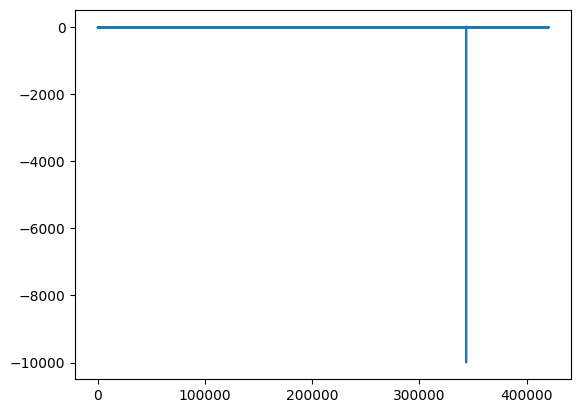

In [ ]:
timeSerie = data.values

plt.plot(timeSerie)
plt.show()

In [ ]:
meanReplaced = np.mean(timeSerie[0:300000])

meanReplaced

2.150413933333333

In [ ]:
result = np.where(timeSerie<0)[0]
result

array([343578, 343579, 343580, 343581, 343582, 343583, 343584, 343585,
       343586, 343587, 343588, 343589, 343590, 343591, 343592, 343593,
       343594, 343595])

In [ ]:
for i in result:
  timeSerie[i] = meanReplaced

In [ ]:
# Normalización de los datos
timeSerie = data.values
timeSerie = (timeSerie-min(timeSerie))/(max(timeSerie)-min(timeSerie))

time = np.arange(0, len(timeSerie),1)

In [ ]:
X = np.zeros([len(timeSerie)-prediction_horizon-window+1, window])
y = np.zeros([len(timeSerie)-prediction_horizon-window+1, prediction_horizon])

for i in range(X.shape[0]):
  X[i,:] = timeSerie[i:i+window]
  y[i,:] = timeSerie[i+window: i+window+prediction_horizon]

X = torch.from_numpy(X)
y = torch.from_numpy(y)



In [ ]:
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_ = np.reshape(X_, (X_.shape[0], X_.shape[1], 1)).float()
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)).float()

X_.shape, X_test.shape, y_.shape, y_test.shape


(torch.Size([336398, 50, 1]),
 torch.Size([84100, 50, 1]),
 torch.Size([336398, 4]),
 torch.Size([84100, 4]))

In [ ]:
train_dataset = TensorDataset(torch.tensor(X_, dtype=torch.float32),
                              torch.tensor(y_, dtype=torch.float32))

test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                             torch.tensor(y_test, dtype=torch.float32))


<ipython-input-17-b9f6c49f1090>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_, dtype=torch.float32),
<ipython-input-17-b9f6c49f1090>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_, dtype=torch.float32))
<ipython-input-17-b9f6c49f1090>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
<ipython-input-17-b9f6c49f1090>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.cl

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# **Forecasting**

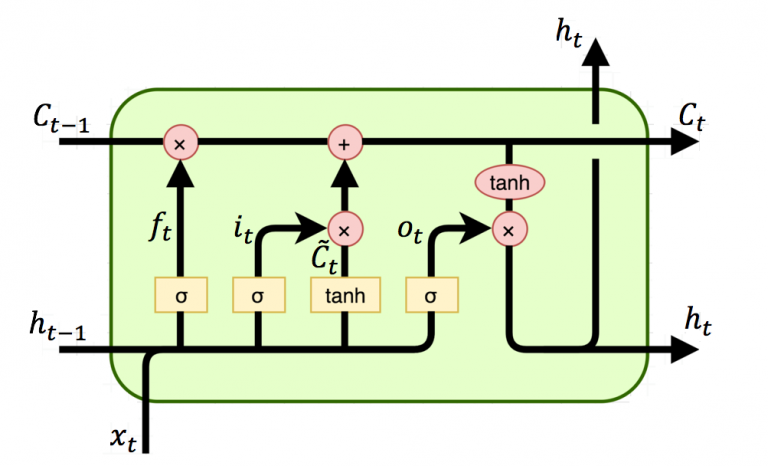

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Asegurar que los tensores ocultos estén en el mismo dispositivo que x
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=x.device)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out

In [ ]:
model = LSTMModel(input_dim=1, hidden_dim=64, output_dim=4, num_layers=2).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Listas para almacenar las pérdidas
train_losses = []
test_losses = []

# Entrenamiento
for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    # Bucle de entrenamiento
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)  # Acumular la pérdida ponderada por el tamaño del lote

    # Promedio de la pérdida de entrenamiento
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)  # Guardamos el rendimiento por cada época
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}")

    # Evaluación en el conjunto de prueba
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item() * X_batch.size(0)  # Acumular la pérdida ponderada por el tamaño del lote

    # Promedio de la pérdida de prueba
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)  # Guardamos el rendimiento por cada época
    print(f"Test Loss: {test_loss:.4f}")

Epoch [1/30], Loss: 0.0008
Test Loss: 0.0006
Epoch [2/30], Loss: 0.0006
Test Loss: 0.0006
Epoch [3/30], Loss: 0.0006
Test Loss: 0.0006
Epoch [4/30], Loss: 0.0006
Test Loss: 0.0006
Epoch [5/30], Loss: 0.0006
Test Loss: 0.0007
Epoch [6/30], Loss: 0.0006
Test Loss: 0.0006
Epoch [7/30], Loss: 0.0006
Test Loss: 0.0006
Epoch [8/30], Loss: 0.0006
Test Loss: 0.0006
Epoch [9/30], Loss: 0.0006
Test Loss: 0.0006
Epoch [10/30], Loss: 0.0006
Test Loss: 0.0006
Epoch [11/30], Loss: 0.0006
Test Loss: 0.0006
Epoch [12/30], Loss: 0.0006
Test Loss: 0.0006
Epoch [13/30], Loss: 0.0006
Test Loss: 0.0006
Epoch [14/30], Loss: 0.0006
Test Loss: 0.0006
Epoch [15/30], Loss: 0.0006
Test Loss: 0.0006
Epoch [16/30], Loss: 0.0006
Test Loss: 0.0006
Epoch [17/30], Loss: 0.0006
Test Loss: 0.0006
Epoch [18/30], Loss: 0.0006
Test Loss: 0.0006
Epoch [19/30], Loss: 0.0006
Test Loss: 0.0006
Epoch [20/30], Loss: 0.0006
Test Loss: 0.0006
Epoch [21/30], Loss: 0.0006
Test Loss: 0.0006
Epoch [22/30], Loss: 0.0006
Test Loss: 0.00

#**Results**

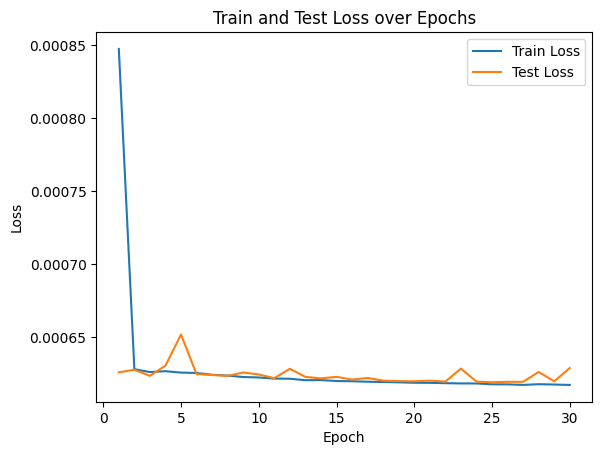

In [ ]:
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Test Loss over Epochs')
plt.show()

In [ ]:
# Crea listas para almacenar las métricas globales
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_true_all.append(y_batch.cpu().numpy())

        # Predicciones para cada horizonte
        y_pred_batch = []

        for horizon in range(prediction_horizon):
            # Asegúrate de que la salida del modelo sea acorde con el horizonte
            output = model(X_batch)  # Predicción para el paso actual
            y_pred_batch.append(output[:, horizon-1].cpu().numpy())  # Tomamos la predicción para el horizonte específico

        y_pred_all.append(np.array(y_pred_batch).T)  # Transponemos para que la forma sea correcta

# Concatenar las predicciones y los valores verdaderos
y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)


In [ ]:
col_names, MSE, MSLE, MAE, R2 = ['Metrics'], ["MSE"], ["MSLE"], ["MAE"], ["R2"]
for i in range(prediction_horizon):
    # Predicciones y valores reales para el horizonte específico
    y_true_horizon = y_true_all[:, i]
    y_pred_horizon = y_pred_all[:, i]

    col_names.append(str(i+1))
    MSE.append(mean_squared_error(y_true_horizon, y_pred_horizon))
    MSLE.append(mean_squared_log_error(y_true_horizon, y_pred_horizon))
    MAE.append(mean_absolute_error(y_true_horizon, y_pred_horizon))
    R2.append(r2_score(y_true_horizon, y_pred_horizon))

data = [MSE, MSLE, MAE, R2]
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))


╒═══════════╤═════════════╤═════════════╤═════════════╤═════════════╕
│ Metrics   │           1 │           2 │           3 │           4 │
╞═══════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ MSE       │ 0.000418732 │ 0.000586667 │ 0.00073426  │ 0.000832762 │
├───────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│ MSLE      │ 0.000337978 │ 0.000478746 │ 0.000593218 │ 0.000676611 │
├───────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│ MAE       │ 0.0149171   │ 0.0173074   │ 0.0192554   │ 0.0206268   │
├───────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│ R2        │ 0.857063    │ 0.800266    │ 0.751949    │ 0.716709    │
╘═══════════╧═════════════╧═════════════╧═════════════╧═════════════╛


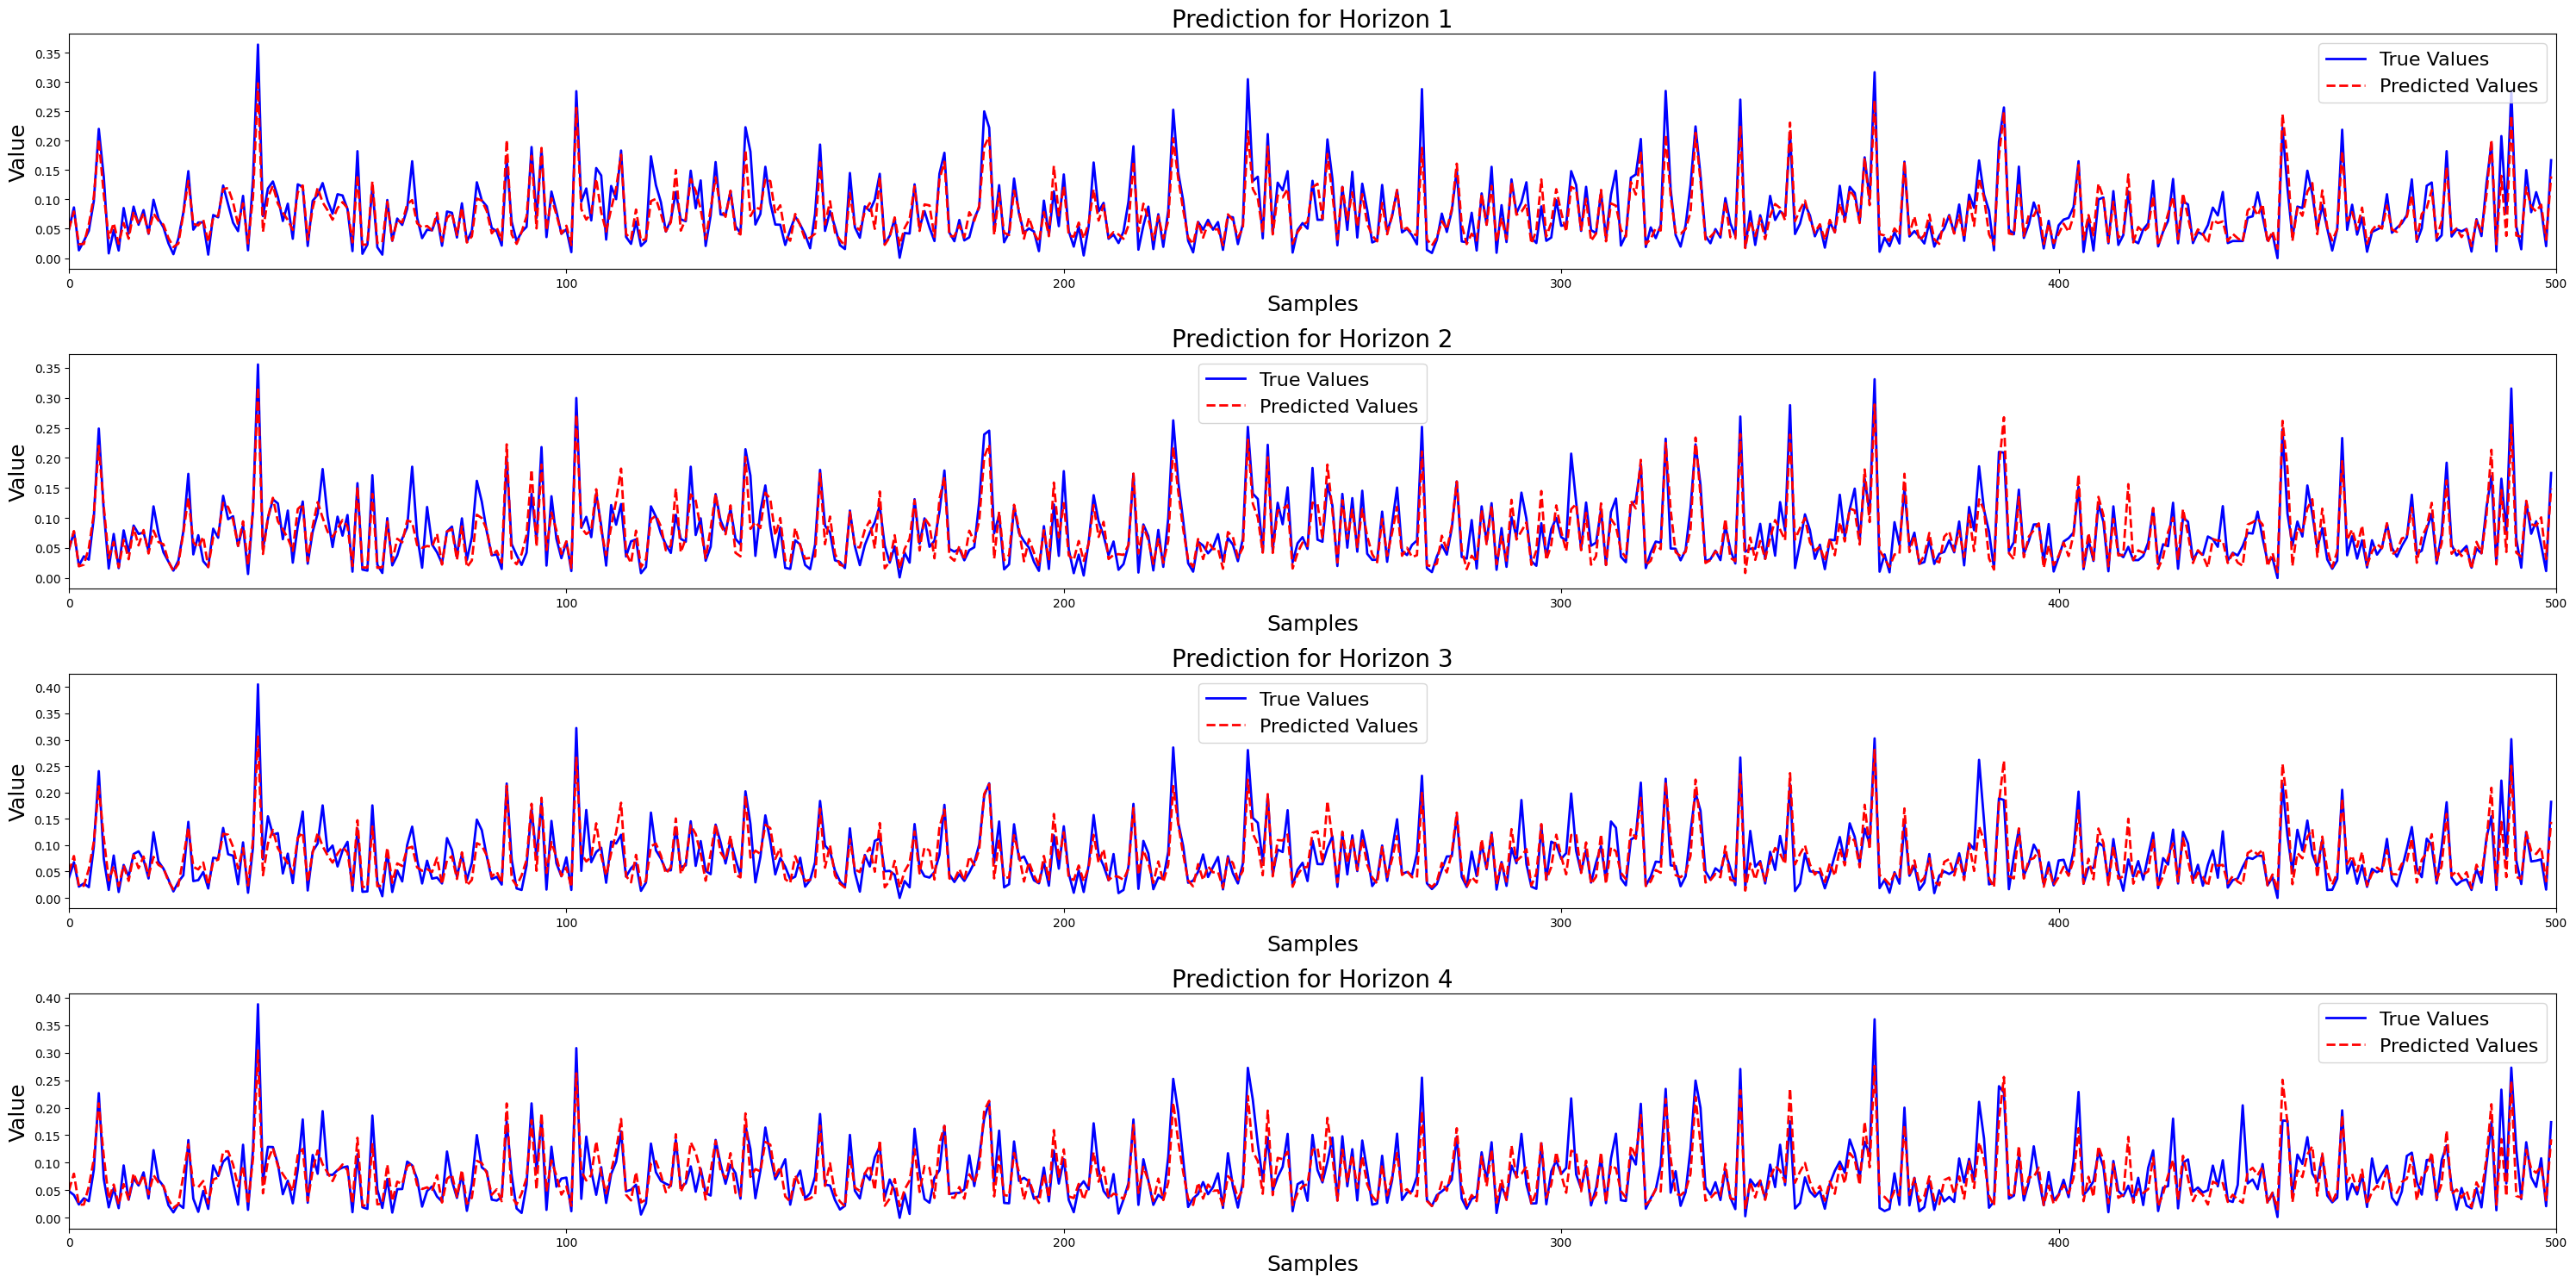

In [ ]:
plt.figure(figsize=(30, 15))

for i in range(prediction_horizon):
    plt.subplot(4, 1, i+1)
    plt.plot(y_true_all[:, i][0:500], label="True Values", color='blue', linewidth=2)
    plt.plot(y_pred_all[:, i][0:500], label="Predicted Values", color='red', linestyle='--', linewidth=2)
    plt.title(f"Prediction for Horizon {i+1}", fontsize=20)
    plt.xlabel('Samples', fontsize=18)
    plt.ylabel('Value', fontsize=18)
    plt.xlim(0, 500)
    plt.legend(fontsize=16)

plt.tight_layout()
plt.show()